# The algorithm behind identifying deviations in K2

K2 is an analysis tool for identifying deviations in district heating consumption. It is rather simple to visually identify deviation for a measuring station but to do so for thousands of stations a statistical method is needed. In this document we describe the method used by K2 to identify deviations in a district heating system.

The method to find deviaitons in K2 is originating from the master thesis "Tool for evaluation of energy efficiency, based on heat
power signature analyses" by Peter Lindquist at Chalmers university of technology (2010). In the thesis he developed an evaluation method where a power signature for a certain time period is compared to a reference period chosen for a time period where the measuring station did not show any deviating behaviour. The reference period is preferably chosen for a full year to take into account seasonal effects. A model where energy consumption is a function of the outdoor temperature, is fitted to the reference period which then is used to predict new values for the evaluation time period. If the observed values is deviating to much from the predicted values it is classified as an alarm.

The model is a so called segmented regression or piecewise regression that fits connected straight lines within separate segments in the data, here defined by a set of temperature intervals. The model was originally developed by Mauro Munoz in his master thesis "Quality study for district heating measuring stations" at Chalmers University of Technology (2005) and later implemented by Öystein Andersen from Ferrologic. In this document we will go through how the model is working using test and reference datasets downloaded from K2.

## Segmented regression

The reference data contains energy consumption for the time period 2017-01-01 to 2017-12-31 (default) and test data for the time period 2017-01-01 to 2020-02. The model is calculated in the same way for both energy consumption and flow but here we focus on the energy consumption.

The model will be fitted in four segments defined by the pre determined temperature intervals: less than 2°C, between 2°C and 9°C, between 9°C and 15°C and above 15°C. If the number of observations within a temperature interval is less than five or if the difference between maximum and minimum temperature within the interval is less than two the observations within that temperature interval will be excluded when fitting the model. For the reference dataset used here no observations will need to be excluded.

We will start by looking at our test and reference data by plotting energy consumption as a function of outdoor temperature. The colors show which temperature interval the observation belongs to.

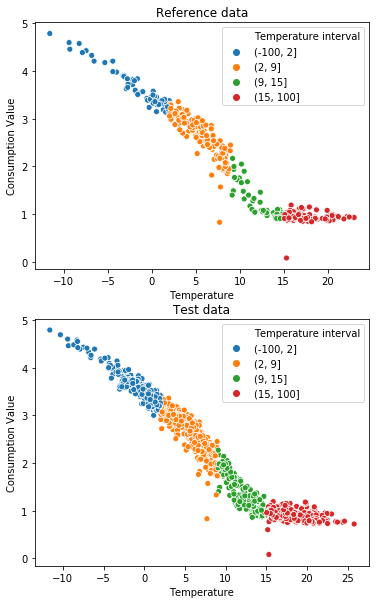

In [1]:
%matplotlib inline 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from backend.Matrix import Matrix
from backend.Group import Group
from backend.Point import Point
from standard_deviation import StandardDeviation #Kopierad från källkoden, går ej att importera


#temperaturintervall, hårdkodat i _default_controller.py
BREAKPOINTS = [-5, 2, 9, 15, 20]

tds9 = pd.read_csv('data/TDS9_test.csv', sep=';')
tds9['Timestamp'] = pd.to_datetime(tds9.Timestamp)
tds9['Consumption From'] = pd.to_datetime(tds9['Consumption From'])
tds9['Consumption To'] = pd.to_datetime(tds9['Consumption To'])

tds9 = tds9[(tds9.Property=='energy') & (tds9.Value > 0.)]

tds9_ref = pd.read_csv('data/TDS9_ref2.csv', sep=';')
tds9_ref['Timestamp'] = pd.to_datetime(tds9_ref.Timestamp)
tds9_ref['Consumption From'] = pd.to_datetime(tds9_ref['Consumption From'])
tds9_ref['Consumption To'] = pd.to_datetime(tds9_ref['Consumption To'])
tds9_ref = tds9_ref[tds9_ref.Property=='energy']

tds9['Temperature interval'] = pd.cut(tds9['Temperature'], [-100] + BREAKPOINTS[1:-1] + [100])
tds9_ref['Temperature interval'] = pd.cut(tds9_ref['Temperature'], [-100] + BREAKPOINTS[1:-1] + [100])

fig, ax =plt.subplots(2,1, figsize = (6,10))
ax[0].set_title('Reference data')
ax[1].set_title('Test data')

sns.scatterplot(x = 'Temperature', y = 'Consumption Value', hue = 'Temperature interval', data = tds9_ref, ax=ax[0])
sns.scatterplot(x = 'Temperature', y = 'Consumption Value',  hue = 'Temperature interval', data = tds9, ax=ax[1]);

Then we fit the regressionmodel to the reference dataset and visualize the model togehter with the observations.

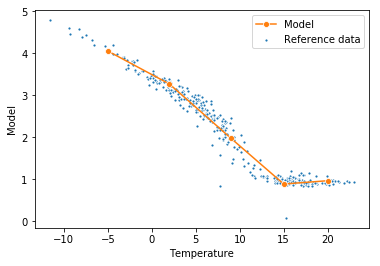

In [2]:
def fill_points_with_data(df):
    points = []
    for index, row in df.iterrows():
        point = Point()
        point.temp = float(row['Temperature'])
        try:
            point.reading = row['Consumption Value'] 
            point.timestamp = row['Timestamp']
            point.consumption_timestamp = row['Consumption From']
            point.breakpoints = BREAKPOINTS
        except:
            None
        points.append(point)
    return points

points_energy = fill_points_with_data(tds9_ref)
points_energy_test = fill_points_with_data(tds9)

# Skapa grupp för referensdata
g_energy = Group()
g_energy.set_breakpoints(BREAKPOINTS)
g_energy.set_points(points_energy)

# Skapa grupp även för test data (används senare)
g_energy_test = Group()
g_energy_test.set_breakpoints(BREAKPOINTS)
g_energy_test.set_points(points_energy_test)

koff = g_energy.calcKoff()
g_energy.updatePointRegression(koff)

#Skapa data grupp för breakpoints för visualisering av modell
breakpoint_df = pd.DataFrame({'Temperature' : BREAKPOINTS})
points_bp = fill_points_with_data(breakpoint_df)
bp_group = Group()
bp_group.set_breakpoints(BREAKPOINTS)
bp_group.set_points(points_bp)
bp_group.updatePointRegression(koff)


ref_modell = pd.DataFrame([[point.reading, point.regression, point.temp] for point in g_energy.points], columns=['Consumption', 'Model', 'Temperature'])
bp_modell = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_group.points], columns=['Consumption', 'Model', 'Temperature'])

import itertools
palette = sns.color_palette()

sns.scatterplot(x = 'Temperature', y = 'Consumption', marker='.', data = ref_modell, label = 'Reference data')
sns.lineplot(x = 'Temperature', y='Model', marker = 'o', data = bp_modell, color = palette[1], label = 'Model')
plt.legend();

The model returns five coefficients, the first one corresponds to the intercept and the other four corresponds to the slope of the four regression lines. We can see that the first three lines have a negative slope where the second and third are almost identical while the fourth line has a slight positive slope.

coefficient  1  : -0.112

coefficient  2  : -0.185

coefficient  3  : -0.182

coefficient  4  : 0.016


In [3]:
k = [print('coefficient ', item[0]+1, ' :',round(item[1], 3)) for item in enumerate(koff[1:])]

coefficient  1  : -0.112
coefficient  2  : -0.185
coefficient  3  : -0.182
coefficient  4  : 0.016


The residuals between predicted and measured value are distributed randomly which from a statistical perspective is desired. On the other hand the variance is not constant over the different temperature intervals, this is because we are fitting a linear model to non linear data.

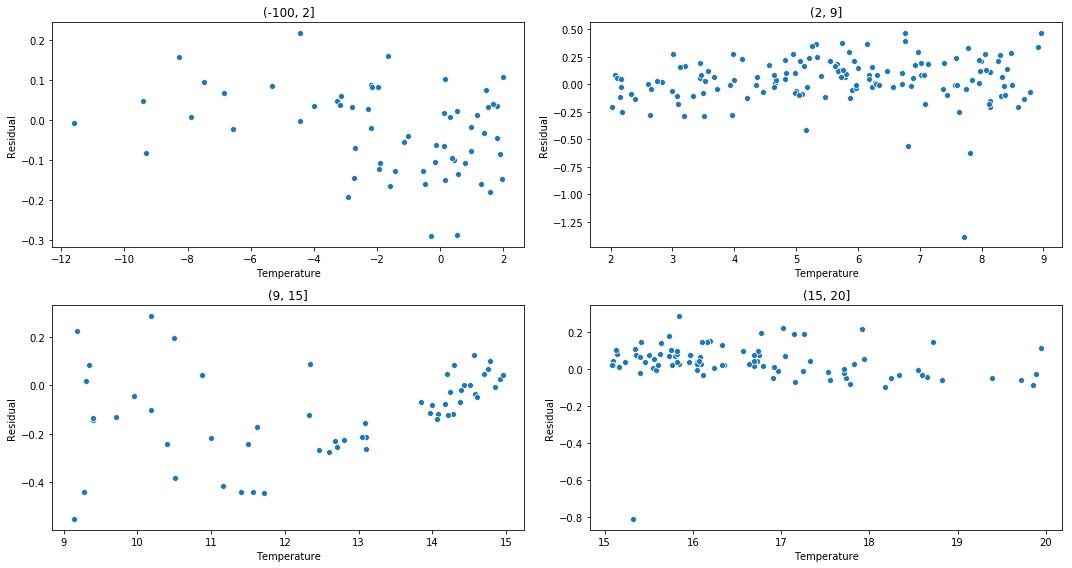

In [4]:
ref_modell['Residual'] = ref_modell['Consumption'] - ref_modell['Model']
ref_modell['Interval'] = pd.cut(ref_modell['Temperature'], [-100] + BREAKPOINTS[1:] + [100])

intervals = ref_modell.Interval.unique()
fig, axes = plt.subplots(2,2, figsize=(15,8))
for i, ax in enumerate(axes.flat):
    d = ref_modell[ref_modell.Interval == intervals[i]]
    sns.scatterplot(x='Temperature', y='Residual', data=d, ax = ax)
    ax.set(title = intervals[i])
    
plt.tight_layout()

The distribution of the residuals is following a normal distribution quite well.

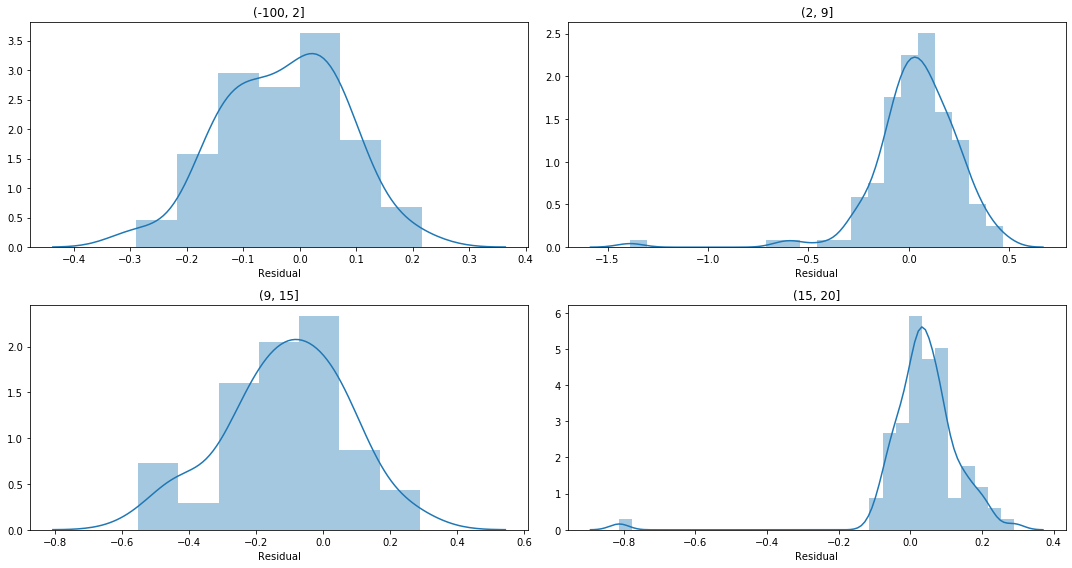

In [19]:
fig, axes = plt.subplots(2,2, figsize=(15,8))
for i, ax in enumerate(axes.flat):
    d = ref_modell[ref_modell.Interval == intervals[i]]
    ax.set(title=intervals[i])
    sns.distplot(d.Residual, ax = ax)
plt.tight_layout()

## Stations with multiple consumption signatures
Some stations show two or more energy consumption signatures for the same outdoor temperature. This is common for offices and schools for example where the energy consumption is high during working days when there are people in the buildings and instead a low consumption during weekends when the buildings are empty. K2 can identify such patterns and fit separate models to the different signatures.
To illustrate one such case we look flow data downloaded from K2 for the test station TDS3 where the two signatures are visible for both reference and test data.

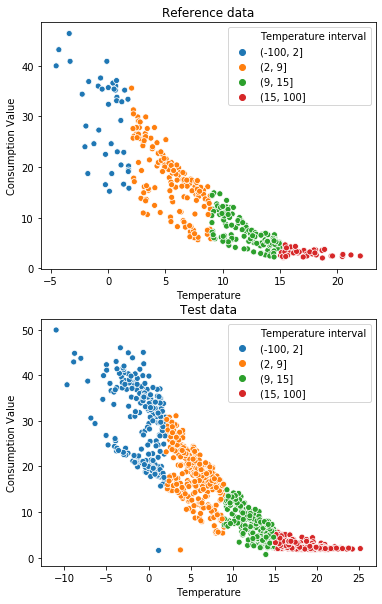

In [10]:
tds3 = pd.read_csv('data/TDS3_test.csv', sep=';', decimal=',')
tds3.columns = [x.replace('_', ' ').title() for x in tds3.columns]

tds3['Timestamp'] = pd.to_datetime(tds3.Timestamp)
tds3['Consumption From'] = pd.to_datetime(tds3['Consumption From'])
tds3['Consumption To'] = pd.to_datetime(tds3['Consumption To'])

tds3 = tds3[(tds3.Property=='flow') & (tds3.Value > 0.)]

tds3_ref = pd.read_csv('data/TDS3_ref.csv', sep=';', decimal = ',')
tds3_ref.columns = [x.replace('_', ' ').title() for x in tds3_ref.columns]
tds3_ref['Timestamp'] = pd.to_datetime(tds3_ref.Timestamp)
tds3_ref['Consumption From'] = pd.to_datetime(tds3_ref['Consumption From'])
tds3_ref['Consumption To'] = pd.to_datetime(tds3_ref['Consumption To'])
tds3_ref = tds3_ref[(tds3_ref.Property=='flow') & (tds3_ref.Value > 0.)]

tds3['Temperature interval'] = pd.cut(tds3['Temperature'], [-100] + BREAKPOINTS[1:-1] + [100])
tds3_ref['Temperature interval'] = pd.cut(tds3_ref['Temperature'], [-100] + BREAKPOINTS[1:-1] + [100])

fig, ax =plt.subplots(2,1, figsize = (6,10))
ax[0].set_title('Reference data')
ax[1].set_title('Test data')

sns.scatterplot(x = 'Temperature', y = 'Consumption Value', hue = 'Temperature interval', data = tds3_ref, ax=ax[0])
sns.scatterplot(x = 'Temperature', y = 'Consumption Value',  hue = 'Temperature interval', data = tds3, ax=ax[1]);

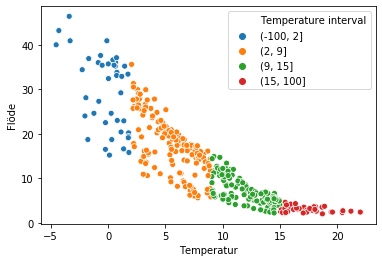

In [152]:
ax = sns.scatterplot(x = 'Temperature', y = 'Consumption Value', hue = 'Temperature interval', data = tds3_ref)
ax.set(ylabel='Flöde', xlabel = 'Temperatur')

K2 decides if to create grouped data by first fitting one model to all data points. After that, all observations under the regression line is defined as one group and all observations above the regression line is defined as another group and two new models are fitted for the two new groups. K2 continues with the splitted data if the total residual sum of squares between all observations and their predicted value is less when using two groups and two models compared to when using only one group and one model. The next plot shows one regression model fitted to the full dataset toghether with the subsequent split of observations into two groups, one over the line and one under.

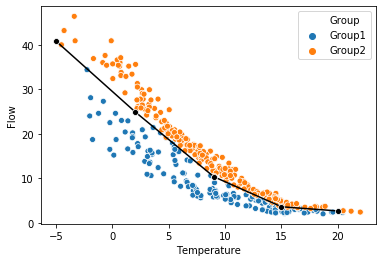

In [11]:
points_flow = fill_points_with_data(tds3_ref)
points_flow_test = fill_points_with_data(tds3)

# Skapa grupp för referensdata
g_flow = Group()
g_flow.set_breakpoints(BREAKPOINTS)
g_flow.set_points(points_flow)

koff_orig = g_flow.calcKoff()
g_flow.updatePointRegression(koff_orig)
bp_group.updatePointRegression(koff_orig)
bp_modell_orig = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_group.points], columns=['Flow', 'Model', 'Temperature'])

from backend.Matrix import Matrix
from backend.Group import Group

max_groups = int(3)
kvot_splittring = float(0.25)
calc_times = int(10)
tolerance = float(0.000001)

_from = pd.to_datetime("2017-01-01T00:00:00.000Z") #dessa påverkar ej koefficientberäkning
to =pd.to_datetime("2017-12-31T00:00:00.000Z")

matrix_flow = Matrix(BREAKPOINTS)
matrix_flow.addGroup(g_flow)

matrix_flow.split(max_groups, kvot_splittring)

ref_modell_g1 = pd.DataFrame([[point.reading, point.regression, point.temp] for point in matrix_flow.groups[0].points], columns=['Flow', 'Model', 'Temperature'])
ref_modell_g1['Group'] = 'Group1'
ref_modell_g2 = pd.DataFrame([[point.reading, point.regression, point.temp] for point in matrix_flow.groups[1].points], columns=['Flow', 'Model', 'Temperature'])
ref_modell_g2['Group'] = 'Group2'

ref_modell_flow = pd.concat([ref_modell_g1, ref_modell_g2])

sns.scatterplot(x = 'Temperature', y = 'Flow', hue = 'Group', data = ref_modell_flow)
ax = sns.lineplot(x = 'Temperature', y = 'Model', data = bp_modell_orig, color = 'k', marker = 'o')
ax.set_ylabel('Flow');

Two new models fitted to the grouped data:

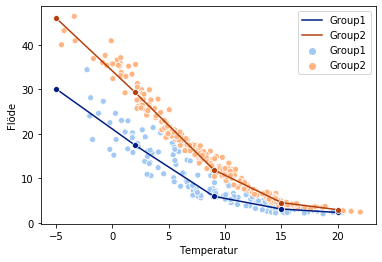

In [156]:
from copy import deepcopy

bp_model_g1 = deepcopy(bp_group)
bp_model_g2 = deepcopy(bp_group)

bp_model_g1.updatePointRegression(matrix_flow.groups[0].arrKoff)
bp_model_g2.updatePointRegression(matrix_flow.groups[1].arrKoff)

bp_g1 = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_model_g1.points], columns=['Flow', 'Model', 'Temperature'])
bp_g1['Group'] = 'Group1'
bp_g2 = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_model_g2.points], columns=['Flow', 'Model', 'Temperature'])
bp_g2['Group'] = 'Group2'
bp_models = pd.concat([bp_g1, bp_g2])

sns.scatterplot(x = 'Temperature', 
                y = 'Flow', 
                hue = 'Group',
                palette = 'pastel',
                data = ref_modell_flow)
ax = sns.lineplot(x = 'Temperature', 
                  y = 'Model', 
                  hue = 'Group', 
                  data = bp_models, 
                  palette = 'dark', 
                  marker = 'o')
ax.set_ylabel('Flow')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3] + handles[4:], 
          labels=labels[1:3] + labels[4:])

As a next step, K2 checks if the observations are placed into the correct group. This is done by checking the residual between all observations and the two regression lines, the observation is then associated with the group where the residual is smallest. After that, two new regression lines are calculated on the new groups and another check is performed if all observations belongs to the group where the residual to the regression line is smallest. This correction of group classification and subsequent calculation of new regression lines is performed a maximum of 10 times or until the total residual sum of squares is not changing more than the tolerance parameter 0.000001.

For TDS3, 19 observations are moved, 3 from group 1 to group 2 and 16 observations from group 2 to group 1. The corrected observations are highlighted with darker color in the plot below.

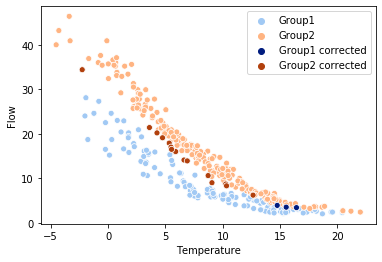

In [148]:
matrix_flow.base(calc_times, tolerance)

ref_modell_g1_base = pd.DataFrame([[point.reading, point.regression, point.temp] for point in matrix_flow.groups[0].points], columns=['Flow', 'Model', 'Temperature'])
ref_modell_g1_base['Group'] = 'Group1'
ref_modell_g2_base = pd.DataFrame([[point.reading, point.regression, point.temp] for point in matrix_flow.groups[1].points], columns=['Flow', 'Model', 'Temperature'])
ref_modell_g2_base['Group'] = 'Group2'

ref_model_base = pd.concat([ref_modell_g1_base, ref_modell_g2_base])
#sns.scatterplot(x = 'Temperature', y = 'Flow', hue = 'Group', data = ref_model_base)
ref_model_merged = pd.merge(ref_modell_flow, ref_model_base, on = ['Temperature', 'Flow'])

ref_model_merged['Corrected'] = np.where(ref_model_merged.Group_x != ref_model_merged.Group_y, ' corrected', '')
ref_model_merged['Corrected_group'] = ref_model_merged.Group_y + ref_model_merged.Corrected

sns.scatterplot(x = 'Temperature', 
                y = 'Flow', 
                hue = 'Group_y',
                palette = 'pastel',
                data = ref_model_merged)
ax = sns.scatterplot(x = 'Temperature', 
                y = 'Flow', 
                hue = 'Corrected_group', 
                hue_order = ['Group1 corrected', 'Group2 corrected'], 
                palette = 'dark', 
                data = ref_model_merged[ref_model_merged.Corrected==' corrected'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3] + handles[4:], 
          labels=labels[1:3] + labels[4:]);

The new regression line for group 1 differ slightly from the original model while almost identical for group 2.

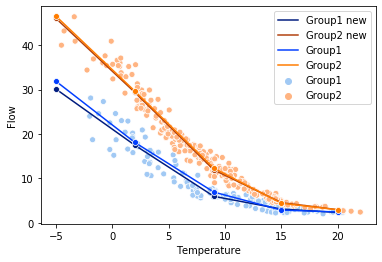

In [144]:
bp_model_g1_corr = deepcopy(bp_group)
bp_model_g2_corr = deepcopy(bp_group)

bp_model_g1_corr.updatePointRegression(matrix_flow.groups[0].arrKoff)
bp_model_g2_corr.updatePointRegression(matrix_flow.groups[1].arrKoff)

bp_g1_corr = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_model_g1_corr.points], columns=['Flow', 'Model', 'Temperature'])
bp_g1_corr['Group'] = 'Group1 new'
bp_g2_corr = pd.DataFrame([[point.reading, point.regression, point.temp] for point in bp_model_g2_corr.points], columns=['Flow', 'Model', 'Temperature'])
bp_g2_corr['Group'] = 'Group2 new'
bp_models_corr = pd.concat([bp_g1_corr, bp_g2_corr])

sns.scatterplot(x = 'Temperature', 
                y = 'Flow', 
                hue = 'Group_y', 
                palette = 'pastel',
                data = ref_model_merged)
sns.lineplot(x = 'Temperature', 
             y = 'Model', 
             hue = 'Group', 
             data = bp_models_corr, palette = 'dark', marker = 'o')

ax = sns.lineplot(x = 'Temperature', 
                  y = 'Model', 
                  hue = 'Group', 
                  data = bp_models, palette = 'bright', marker = 'o')
ax.set_ylabel('Flow')

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:3] + handles[4:6] + handles[7:], 
          labels=labels[1:3] + labels[4:6] + labels[7:]);

## Alarm classification
As a next step we use the model fitted to the reference data to predict values for the test dataset. The alarm classification model in K2 is defining an observation as an alarm if the absolute difference between measured and predicted value is deviating more than 2.2 times the standard deviation of the reference data within the relevant temperature interval.

In [7]:
g_energy_test.updatePointRegression(koff)
test_modell = pd.DataFrame([[point.reading, point.regression, point.temp] for point in g_energy.points], columns=['Mätvärde', 'Modell', 'Temperatur'])

In [8]:
def larm(row, std_cutoff=2.):
    standard_deviation = row['stdav']
    diff = row['resid']
    max_standard_deviation = std_cutoff
    if (abs(diff)/standard_deviation) > max_standard_deviation:
        return 'critical'
    else:
        return 'ok'

# calculate std av for this group
stddev = StandardDeviation(BREAKPOINTS) # Initierar standard deviation klass
stddev.import_from_group(g_energy) # För över reading, regression, temp från grupp till stddev klass, lagras som pandas dataframe
stddev.calc_standard_deviation() # Beräknar standardavvikelsen per temperaturintervall

test_modell['resid'] = test_modell['Mätvärde'] - test_modell['Modell']
test_modell['temp_intervall'] = pd.cut(ref_modell['Temperatur'], [-100] + BREAKPOINTS[1:] + [100])

std = pd.DataFrame(stddev._dataframe.groupby(['temp_intervall'])[
            'consumption_norm'].std().rename('stdav'))
test_modell = test_modell.join(std, on = 'temp_intervall')
test_modell['larm'] = test_modell.apply(lambda row: larm(row), axis=1)

KeyError: 'Temperatur'

Finally we can visualize the observations in the test data defined as deviating.

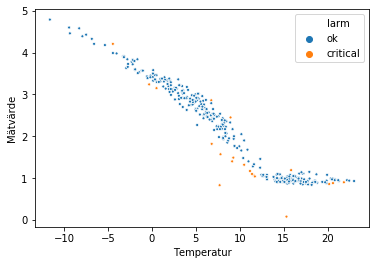

In [12]:
sns.scatterplot(x ='Temperatur', y = 'Mätvärde', hue='larm', marker = '.', data = test_modell)


How well the method described here works is highly dependent on finding a good reference period for the station, something not always easy or even possible. In the future we will look into other ways of building models on measured data not depending on a reference period to identify deviating observations.